# 电量消耗时间序列预测

## 项目背景

时间序列预测需求在日常生活中普遍存在，如天气预测、电能消耗、销量预测、顾客留存等，其中对于制造业而言若能把握市场供需关系准确、提前备货将为企业带来显著收益，近年来神经网络结构研究的发展为时间序列预测模型注入了全新的血液。
为了强化对时间序列预测任务的理解，同时进一步验证各类算法/模型对于相关任务的适用性，特别是传统模型与Transformer 架构模型之间的性能差异，为后续供应链算法及其他类似任务需求积累技术实践经验，遂提出本课题。

此数据集包含370个客户端的用电量。

数据集没有缺失值。 每行代表每15分钟的用电量，以kW为单位。要转换以千瓦时为单位的值，须除以4。每列代表一个客户端。

数据集使用 csv 格式保存为 txt，使用分号(;)分隔。 第一列以字符串形式呈现日期和时间，格式为“yyyy-mm-dd hh：mm：ss” 其他列显示浮点值，消耗量（以 kW 为单位）。

## 导入必要的库

In [72]:
import pandas as pd 
import numpy as np
import argparse
import copy
import time
import os
from datetime import datetime as dt #数据索引改为时间
import statsmodels.api as sm     # acf,pacf检验
from statsmodels.tsa.stattools import adfuller  # adf检验
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox #随机性检验库
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

In [125]:
parser = argparse.ArgumentParser(description='ARIMA Long Sequences Forecasting')
parser.add_argument('--pred_len', type=int, default=48, help='prediction sequence length')

args = parser.parse_args(args=[])

## 导入数据

In [74]:
# 导入数据
ECL_data = pd.read_table('./LD2011_2014.txt', sep=';', low_memory=False)

In [75]:
ECL_data.head(6)

Unnamed: 0 MT_001 MT_002 MT_003 MT_004 MT_005 MT_006 MT_007  \
0  2011-01-01 00:15:00      0      0      0      0      0      0      0   
1  2011-01-01 00:30:00      0      0      0      0      0      0      0   
2  2011-01-01 00:45:00      0      0      0      0      0      0      0   
3  2011-01-01 01:00:00      0      0      0      0      0      0      0   
4  2011-01-01 01:15:00      0      0      0      0      0      0      0   
5  2011-01-01 01:30:00      0      0      0      0      0      0      0   

  MT_008 MT_009  ... MT_361 MT_362 MT_363 MT_364 MT_365 MT_366 MT_367 MT_368  \
0      0      0  ...      0    0.0      0      0      0      0      0      0   
1      0      0  ...      0    0.0      0      0      0      0      0      0   
2      0      0  ...      0    0.0      0      0      0      0      0      0   
3      0      0  ...      0    0.0      0      0      0      0      0      0   
4      0      0  ...      0    0.0      0      0      0      0      0      0   
5      0      0  ...      0    0.0      0      0      0      0      0      0   

  MT_369 MT_370  
0      0      0  
1      0      0  
2      0      0  
3      0      0  
4      0      0  
5      0      0  

[6 rows x 371 columns]

In [76]:
# 查看数据形式
ECL_data.shape

(140256, 371)

## 数据预处理

In [77]:
# 更改列名
ECL_data.rename(columns = {"Unnamed: 0": "time"}, inplace = True)

In [78]:
# 筛选出MT_320用户
data = pd.DataFrame(ECL_data[['time', 'MT_320']])

In [79]:
data.head(5)

time            MT_320
0  2011-01-01 00:15:00  62,5195094760312
1  2011-01-01 00:30:00  58,6176142697882
2  2011-01-01 00:45:00  60,8472686733556
3  2011-01-01 01:00:00    59,17502787068
4  2011-01-01 01:15:00  58,6176142697882

In [80]:
# 查看缺失值
data.isnull().sum(axis=0)

time      0
MT_320    0
dtype: int64

In [81]:
# 转换时间列为时间戳格式
data['time'] = pd.to_datetime(data['time'])

In [82]:
# 转换用电量特殊符号
data = data.replace(r",", ".",regex = True)
# 更改数据类型为float
data['MT_320'] = data['MT_320'].astype("float") 
# 将用电量单位改为kwh
data['MT_320'] = data['MT_320'] / 4

In [83]:
# 将数据按照 1 小时进行分组  
data = data.groupby(pd.Grouper(key='time', freq='1H')).sum()

In [84]:
# 筛选2012年和2013年的用电数据
data = data['2012-01-01 00:00:00':'2013-12-31 23:45:00']

In [85]:
data.shape

(17544, 1)

In [86]:
data.head(10)

MT_320
time                          
2012-01-01 00:00:00  51.506410
2012-01-01 01:00:00  50.110089
2012-01-01 02:00:00  47.318841
2012-01-01 03:00:00  46.343367
2012-01-01 04:00:00  47.041527
2012-01-01 05:00:00  49.133222
2012-01-01 06:00:00  50.249443
2012-01-01 07:00:00  52.341137
2012-01-01 08:00:00  50.387402
2012-01-01 09:00:00  52.481884

In [87]:
# # 将索引设置为时间列
# data['time'] = pd.to_datetime(data['time'])
# data = data.set_index('time')

In [88]:
data.describe()

MT_320
count  17544.000000
mean     102.828073
std       26.197747
min        0.602007
25%       85.023690
50%      108.226031
75%      121.084169
max      205.444537

## 数据探索

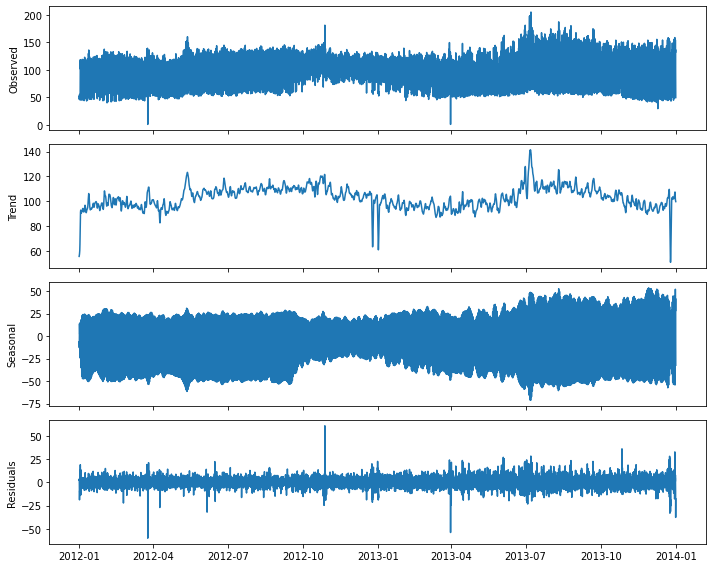

In [89]:
# 将数据分解，查看数据的平稳性、趋势性、季节性
decomposition = STL(data['MT_320'], period=24).fit()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True,figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.tight_layout()

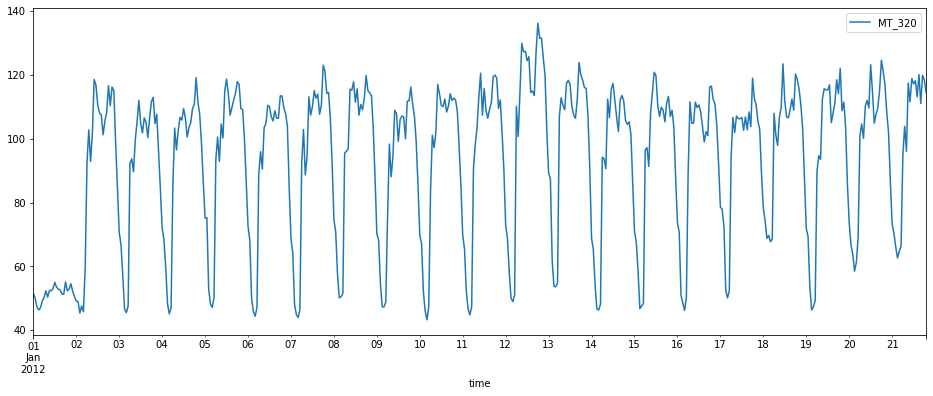

In [90]:
# 季节性
data[0:500].plot(figsize = (16, 6));

## 划分训练和测试数据集

现在已经加载了数据，可以将其划分为训练集、验证集和测试集。要在训练集上训练模型。在模型完成训练后，将使用测试集评估它的准确性。

* **训练集**：90%训练数据
* **测试集**：10%测试数据

In [91]:
train_size = int(len(data) * 0.9)
test_size = len(data) - train_size

## 可视化差异

为了更加直观地看出训练集和测试集的差异，我们在同一张图中用不同颜色区分两个测试集，蓝色为训练集、橙色为测试集。


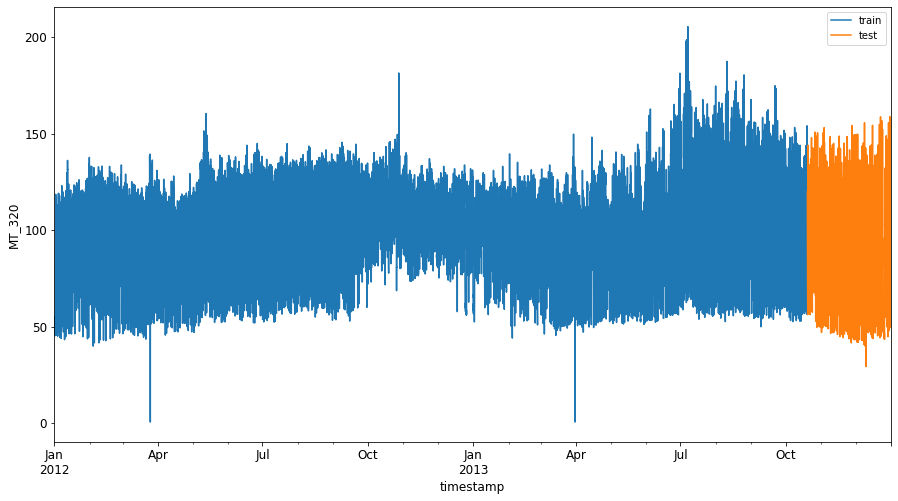

In [92]:
data[:train_size][['MT_320']].rename(columns={'MT_320':'train'}) \
.join(data[train_size:][['MT_320']].rename(columns={'MT_320':'test'}), how='outer')\
.plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('MT_320', fontsize=12)
plt.show()

## 准备训练数据

现在需要通过对数据进行筛选和归一化来为模型训练准备数据。筛选需要的时间段和列的数据，并且对其进行归一化，其作用的是将数据投影在0-1之间。

### 划分原始数据集

In [93]:
# 划分原始数据集
train = data.copy()[:train_size][['MT_320']]
test = data.copy()[train_size:][['MT_320']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (15789, 1)
Test data shape:  (1755, 1)


### 数据标准化

In [94]:
# 使用StandardScaler()对训练数据进行标准化
scaler = StandardScaler()
train['MT_320'] = scaler.fit_transform(train)
train.head(5)

MT_320
time                         
2012-01-01 00:00:00 -2.029112
2012-01-01 01:00:00 -2.083666
2012-01-01 02:00:00 -2.192718
2012-01-01 03:00:00 -2.230829
2012-01-01 04:00:00 -2.203552

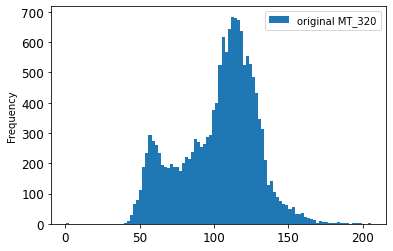

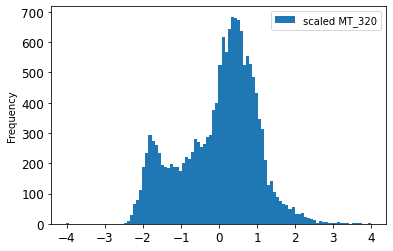

In [95]:
# 原始数据和标准化数据进行可视化比较
data[:train_size][['MT_320']].rename(columns={'MT_320':'original MT_320'})\
.plot.hist(bins=100, fontsize=12)
train.rename(columns={'MT_320':'scaled MT_320'}).plot.hist(bins=100, fontsize=12)
plt.show()

In [96]:
# 根据训练好的归一化模型，对测试集数据归一化
test['MT_320'] = scaler.transform(test)
test.head(5)

MT_320
time                         
2013-10-19 21:00:00  0.651026
2013-10-19 22:00:00  0.350710
2013-10-19 23:00:00 -0.381078
2013-10-20 00:00:00 -1.283550
2013-10-20 01:00:00 -1.341206

## 稳定性检验

1%、%5、%10不同程度拒绝原假设的统计值和ADF Test result的比较，ADF Test result同时小于1%、5%、10%即说明非常好地拒绝该假设。另外，P-value是否非常接近0，接近0，则是平稳的，否则，不平稳。

若不平稳，则需要进行差分，差分后再进行检测。

In [97]:
def adf_val(ts, ts_title):
    '''
    ts: 时间序列数据，Series类型
    ts_title: 时间序列图的标题名称，字符串
    '''     
    # 稳定性（ADF）检验
    adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(ts)  

    name = ['adf', 'pvalue', 'usedlag',
            'nobs', 'critical_values', 'icbest']    
    values = [adf, pvalue, usedlag, nobs, 
              critical_values, icbest]  
    print(list(zip(name, values)))

    return adf, pvalue, critical_values,  
    # 返回adf值、adf的p值、三种状态的检验值

In [98]:
# 读取数据
ts_data = data['MT_320'].astype('float32')  
adf, pvalue1, critical_values = adf_val(
          ts_data, 'raw time series')

[('adf', -8.583618791458504), ('pvalue', 7.610736720440426e-14), ('usedlag', 44), ('nobs', 17499), ('critical_values', {'1%': -3.430723750472268, '5%': -2.8617051832726124, '10%': -2.5668579227683557}), ('icbest', 118012.76321036796)]


adf结果为-8.6， 小于三个level的统计值。pvalue也是接近于0 的，所以是平稳的。

## 白噪声检测

白噪声检验也称为纯随机性检验，当数据是纯随机数据时，再对数据进行分析就没有任何意义了，所以拿到数据后最好对数据进行一个纯随机性检验。

In [99]:
print(acorr_ljungbox(data.MT_320, lags=1)) 

        lb_stat  lb_pvalue
1  13093.854461        0.0


## ARIMA模型实现

可以使用statsmodels 库创建 ARIMA 模型。并遵循以下几个步骤。

* 通过调用SARIMAX()并传入模型参数： p, d, q参数，以及 P, D, Q参数定义模型。
* 通过调用fit()函数为训练数据准备模型。
* 通过调用forecast()函数进行预测，并指定要预测的步骤数(horizon)。

在ARIMA模型中，有3个参数用于帮助对时间序列的主要方面进行建模：季节性、趋势和噪声。

* p：与模型的自回归方面相关的参数，模型中包含的滞后观测数，也称为滞后阶数。
* d：与模型集成部分相关的参数，原始观测值差异的次数，也称为差异度。它影响到应用于时间序列的差分的数量。
* q：与模型的移动平均部分相关的参数。移动平均窗口的大小，也称为移动平均的阶数。

### 确定时间序列的差分 

<AxesSubplot:xlabel='time'>

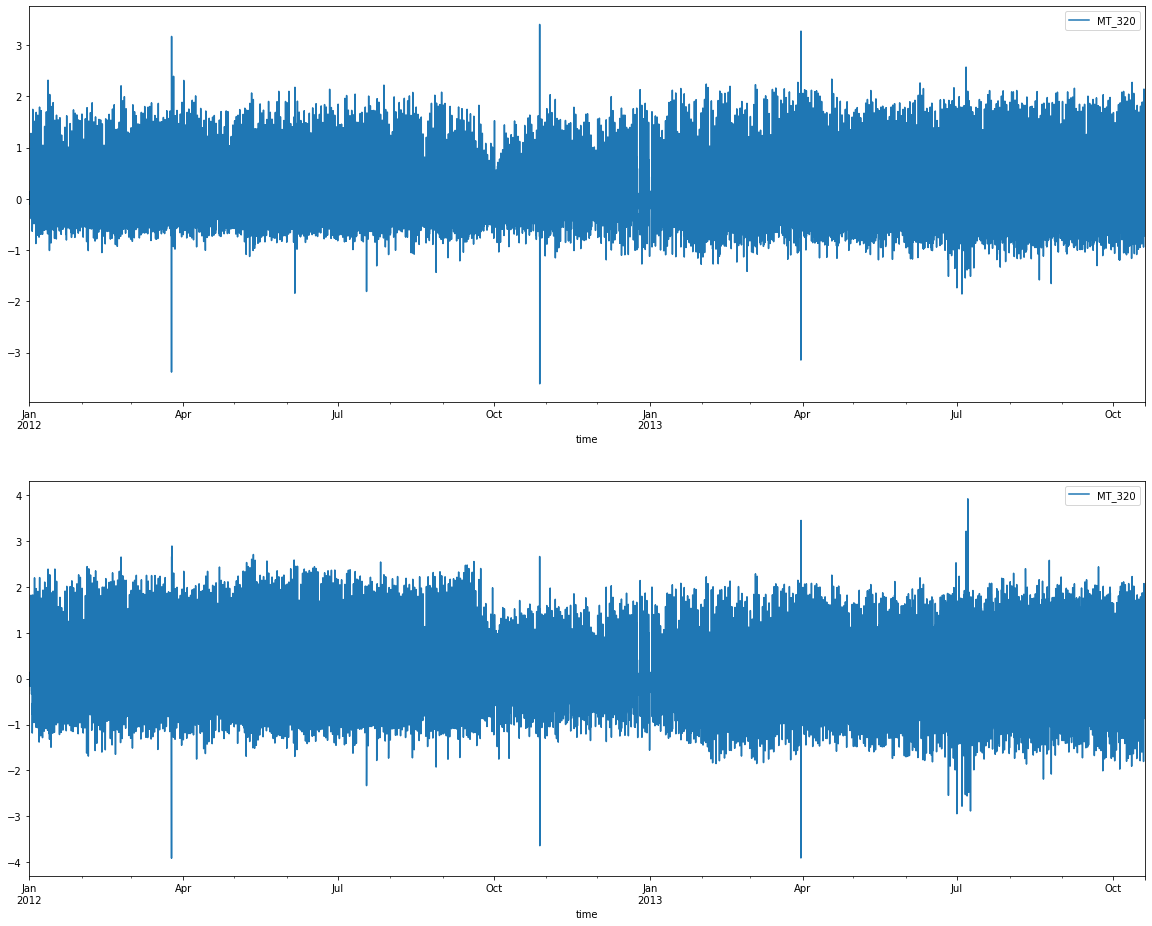

In [100]:
fig = plt.figure(figsize=(20,16))
ax1= fig.add_subplot(211)
diff1 = train.diff(1)
diff1.plot(ax=ax1)
ax2= fig.add_subplot(212)
diff2 = train.diff(2)
diff2.plot(ax=ax2)

可以看出一阶差分的时间序列的均值和方差已经基本平稳，二阶差分后的时间序列与一阶差分相差不大，并且二者随着时间推移，时间序列的均值和方差保持不变。因此可以将差分次数  设置为1。

### 确定合适的 p、q

现在已经得到一个平稳的时间序列，接来下就是选择合适的ARIMA模型，即ARIMA模型中合适的p、q

### 模式识别

可通过计算自相关系数（Autocorrelation Function, SAF）和偏自相关系数（Partial Autocorrelation Function, PACF）。绘制并检查平稳时间序列的自相关图和偏自相关图。

* 自相关（Autocorrelation）： 对一个时间序列，现在值与其过去值的相关性。如果相关性为正，则说明现有趋势将继续保持。
* 偏自相关（Partial Autocorrelation）： 可以度量现在值与过去值更纯正的相关性。

通常情况下:
* 如果说自相关图拖尾，并且偏自相关图在p阶截尾时，此模型应该为AR(p)。
* 如果说自相关图在q阶截尾并且偏自相关图拖尾时，此模型应该为MA(q)。
* 如果说自相关图和偏自相关图均显示为拖尾，那么可结合ACF图中最显著的阶数作为q值，选择PACF中最显著的阶数作为p值，最终建立ARMA(p,q)模型。
* 如果说自相关图和偏自相关图均显示为截尾，那么说明不适合建立ARMA模型。

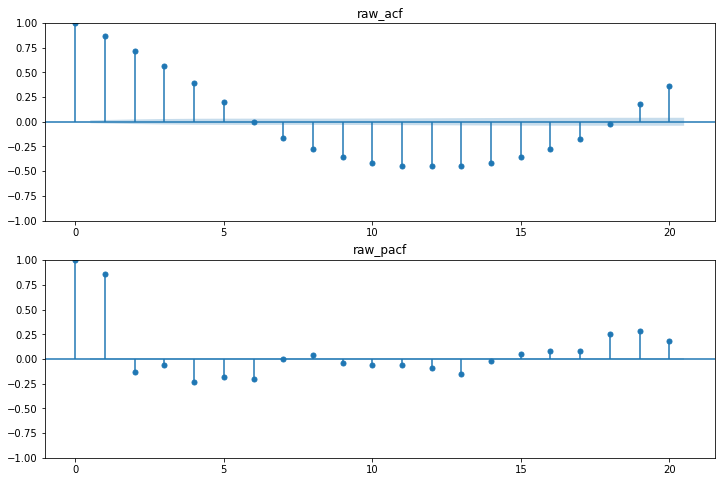

In [101]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(2, 1, figsize=(12, 4*2))
# 自相关
plot_acf(data['MT_320'],lags=20,title='raw_acf', ax=axes[0])  
# 偏自相关
plot_pacf(data['MT_320'],lags=20,title='raw_pacf', ax=axes[1])  
plt.show()
# 其中lags 表示滞后的阶数，以上分别得到acf图和pacf图。

## 模型训练

In [102]:
# 模型训练
start = time.time()
p, d, q, P, D, Q, periods = 2, 0, 3, 1, 0, 1, 24
model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, periods)).fit(disp=-1)
end = time.time()
print(model.summary())
print('Training time:', end - start, 'sec')

/Users/wenchen/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                               MT_320   No. Observations:                15789
Model:             SARIMAX(2, 0, 3)x(1, 0, [1], 24)   Log Likelihood                 972.026
Date:                              Wed, 08 Nov 2023   AIC                          -1928.052
Time:                                      22:18:06   BIC                          -1866.716
Sample:                                  01-01-2012   HQIC                         -1907.753
                                       - 10-19-2013                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6590      0.009    181.797      0.000       1.641       1.677
ar.L2         -0.67

In [126]:
# 模型预测
steps = args.pred_len
fcst = model.forecast(steps)

### 评估模型的准确性

In [127]:
# 模型评估
mse = mean_squared_error(test[:steps], fcst)
print('MSE: %.3f' % mse)

mae = np.mean(np.abs(fcst - test['MT_320'][:steps]))
print('MAE: %.3f' % mae)

MSE: 0.078
MAE: 0.214


<Figure size 1152x576 with 0 Axes>

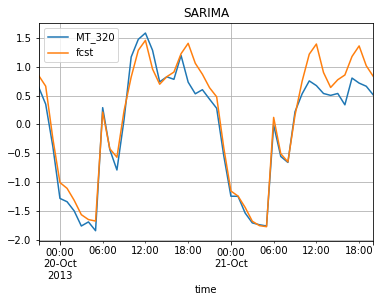

In [128]:
# 可视化
setting = 'pl{}'.format(args.pred_len)
plt.figure(figsize=(16, 8))
test[:steps].plot(label='test')
fcst.plot(label='fcst')
plt.legend()
plt.grid(True)
plt.title('SARIMA')
# 结果保存
folder_path = './results_arima2/' + setting + '/'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
plt.savefig(folder_path+'prediction.png')
plt.show()